In [69]:
import numpy as np
from numpy.random import randn
from collections import deque
#import rloutrading as rlou
import rloutrading_simple_attempt as rlou
from importlib import reload
import matplotlib.pyplot as plt
import torch

## Multidimensional "pseudo" DQN

In [70]:
params = {'kappa': 5.0,
 'sigma': 1.2,
 'xbar': 0.0,
 'phi': 0.005,
 'gamma': 0.9999,
 'c': 0.01,
 'T': 2.0,
 'dt': 0.2,
 'C': 20000.0,
 'D': 20000.0,
 'eps_0': 0.01,
 'xmin': -1,  
 'xmax' : 1,         
 'delta': 1/100_000, #1/1_000_000,
 'K_replacement_freq' : 10_000, #1_000,         
   "n_batches": 64, #32
  #"config": [4, 64, 64, 1],
   "config": 16, #64
   "buffer_size": 1_000}

In [71]:
reload(rlou)
dqntr = rlou.DQNTrading(**params, inventory_min=-2, inventory_max=2,
                        buy_max=1,buy_min=-1, n_q = 0.5, n_price=11)

In [33]:
#%load_ext line_profiler

In [34]:
#%lprun -f dqntr.learn_step -f dqntr.d_step_in_episode dqntr.dq_learn(5, random_shock=True)

In [86]:
iterations = 1_000
dqntr.K_replacement_freq = 500
dqntr.delta = 1/(iterations*10)
dqntr.optimizer.lr= 1e-8
dqntr.dq_learn(iterations, random_shock=True)

100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]


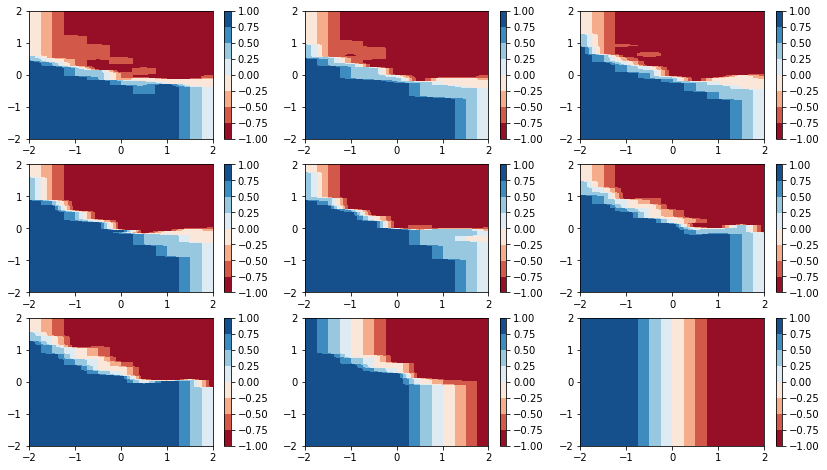

In [87]:
xm = -2#dqntr.xmin
xM = 2#dqntr.xmax
qm = dqntr.inventory_min
qM = dqntr.inventory_max
am = dqntr.buy_min
aM = dqntr.buy_max
n_q = dqntr.n_q
n_x = (xM-xm)/100

inventory = np.arange(qm, qM+n_q, n_q)
prices = np.arange(xm, xM+n_x, n_x)
action_map = np.zeros((len(inventory), len(prices)))

Xs = np.mgrid[qm:qM+n_q:n_q, xm:xM+n_x:n_x]




fig, ax = plt.subplots(3, 3, figsize=(14, 8))
ax = ax.ravel()
#times = [0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
times = [0, 0.2, 0.4, 0.6, 0.8, 1.2, 1.4, 1.6, 1.8]


for ti, axi in zip(times, ax):
    t = ti
    for iq, q in enumerate(inventory):
        for ix, x_price in enumerate(prices):
            possible_action = dqntr.get_possible_actions_zero_inventory_end((dqntr.timesteps==t).argmax(),q)
            X_in = torch.tensor([[t, q, x_price, act] for act in possible_action])
            out = possible_action[dqntr.Q_M.forward(X_in.float()).argmax(axis=0)]
            action_map[iq,ix] = out        
    img = axi.contourf(*Xs, action_map, cmap="RdBu")
    plt.colorbar(img, ax=axi)


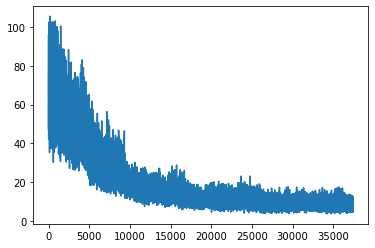

In [88]:
plt.plot(dqntr.error_history[0:]) #

In [85]:
torch.save(dqntr.Q_M.state_dict(), "model_14112020.pt")

In [196]:
X_in = torch.tensor([[0.8, 1, 0, act] for act in [-2,-1,0,1,2]])#torch.randn(5,4)
# t, inventory, price, action
# torch.tensor([[0.7, 90, -5, act] for act in [-2,-1,0,1,2]])
# (t, q, xt), action, reward, (t_prime, q_prime, xt_prime) = self.replay_buffer[sample_index]
dqntr.Q_M.forward(torch.tensor(X_in).float())

/Users/Leandro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


tensor([[9.0188],
        [4.7511],
        [1.4149],
        [1.2984],
        [1.4894]], grad_fn=<AddmmBackward>)

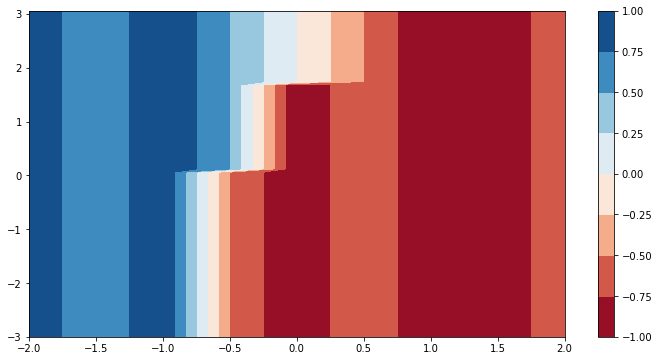

In [16]:
t=0.1
for iq, q in enumerate(inventory):
    for ix, x_price in enumerate(prices):
        possible_action = dqntr.get_possible_actions_zero_inventory_end((dqntr.timesteps==t).argmax(),q)
        X_in = torch.tensor([[t, q, x_price, act] for act in possible_action])
        out = possible_action[dqntr.Q_M.forward(X_in.float()).argmax(axis=0)]
        action_map[iq,ix] = out

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
#ax = ax.ravel()        
        
img = ax.contourf(*Xs, action_map, cmap="RdBu")
plt.colorbar(img, ax=ax)


In [1095]:
CHECK=dqntr.Q_M.forward(X_in.float())#.argmax(axis=0)
CHECK
possible_action = dqntr.get_possible_actions_zero_inventory_end((dqntr.timesteps==t).argmax(),1.5)
possible_action
X_in = torch.tensor([[0.5, 1.5, 1, act] for act in possible_action])
out = possible_action[dqntr.Q_M.forward(X_in.float()).argmax(axis=0)]
#        action_map[iq,ix] = out[0]
out

0.5

In [90]:
dqntr.Q_M.forward(torch.tensor([[0.5, 100, 0, 0]]))

tensor([[130449.6797]], grad_fn=<AddmmBackward>)

In [300]:
X_in = np.random.randn(5, 4)
net.forward(torch.tensor(X_in).float())

tensor([[0.0757],
        [0.0795],
        [0.0973],
        [0.1339],
        [0.0288]], grad_fn=<AddmmBackward>)

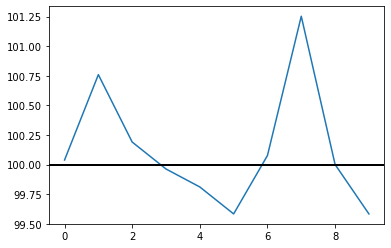

In [628]:
Xt = dqntr.simulate_ou_process(nsims=1)
Xt = dqntr.buckets[np.digitize(Xt, dqntr.buckets)]
plt.plot(Xt)
plt.axhline(y=dqntr.xbar, c="black", linewidth=2)